## Eurofab model training

In [117]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from core.utils import used_keys

from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn import model_selection
from sklearn.metrics import accuracy_score, balanced_accuracy_score, make_scorer

In [6]:
v = 'v3'

Read the training data, groups and labels

In [2]:
%%time
X_train = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/training_data4.pq')
y = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/training_labels4.pq')
groups = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/training_hexagons4.pq')

CPU times: user 57.2 s, sys: 1min 7s, total: 2min 4s
Wall time: 26.8 s


Map the labels to the appropriate aggregation level

In [15]:
cluster_mapping = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

level_cut = cluster_mapping[4]

# assign outliers to the industrial cluster
level_cut[level_cut == 3] = 15
level_cut[level_cut == 4] = 15
level_cut[level_cut == 10] = 15

In [20]:
%%time
y['final_without_noise'] = y['final_without_noise'].map(level_cut.to_dict())
y['final_without_noise'].value_counts()

CPU times: user 201 ms, sys: 53.2 ms, total: 254 ms
Wall time: 254 ms


final_without_noise
13    6820369
8     6299881
14    5304359
6     5302939
7     4773051
5     3736659
1     3541306
9     2683184
12    1947916
11     684260
15     623480
16     548653
2      162239
Name: count, dtype: int64

In [21]:
#sample class size, based on the smallest class
# sample_size = y.value_counts().values[-1]


# sample class size fixed value
sample_size = 100_000


In [22]:
%%time
train_indices = []
classes = y.final_without_noise.unique()
has_building = ~y.index.str.split('_').str[-1].str.startswith('-')
# prague_only = y.index.str.startswith('65806')
for cluster in classes:
    random_indices = np.random.choice(np.where((y.final_without_noise == cluster) & (has_building))[0], sample_size, replace=False)
    train_indices.append(random_indices)

CPU times: user 35.3 s, sys: 1.61 s, total: 36.9 s
Wall time: 36.9 s


In [23]:
train_indices = np.concat(train_indices)

In [24]:
# # limit to prague only
# X_train = X_train[X_train.index.str.startswith('65806')]
# y = y[y.index.str.startswith('65806')]
# groups = groups[groups.index.str.startswith('65806')]

Predict only building classification, so drop empty ETCs.

In [25]:
X_train = X_train.iloc[train_indices].fillna(0)
y = y.iloc[train_indices].fillna(0)
groups = groups.iloc[train_indices].fillna(0)

Setup kfold splitter based on spatial contiguity

In [8]:
gkf = model_selection.StratifiedGroupKFold(n_splits=5)
splits = gkf.split(
    X_train.values,
    y.final_without_noise.values,
    groups=groups.hexagons.values,
)
scoring = {"Balanced Accuracy": make_scorer(balanced_accuracy_score), "Accuracy": make_scorer(accuracy_score)}


In [9]:
factorize_y = y.final_without_noise.factorize()

Setup grid search and evaluation pipeline

In [10]:
# calibrated_forest = CalibratedClassifierCV(
#    estimator=RandomForestClassifier(random_state=123, n_jobs=-1))

# param_grid = {
#     'estimator__max_depth': [2, 4, 6, 8, 20],
#     # 'estimator__max_depth': [2, 4, 6],
#     'estimator__min_samples_split': [2, 50, 100, 200, 400]
#     # 'estimator__min_samples_split': [200, 400]
# }


# search = GridSearchCV(calibrated_forest, param_grid, cv=splits, scoring=scoring, refit="Accuracy", return_train_score=True)

# search.fit(
#     X_train.values,
#     factorize_y[0]
# )

In [11]:
import xgboost

In [12]:
%%time
from xgboost import XGBClassifier
xgb_model = XGBClassifier(nthread=1, learning_rate=0.02, n_estimators=600,)
search = GridSearchCV(
    xgb_model,
    {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        },
    verbose=1,
    n_jobs=-5,
    cv=splits,
    scoring=scoring,
    refit="Accuracy",
    return_train_score=True
)

search.fit(
    X_train.values,
    factorize_y[0]
)

Fitting 5 folds for each of 405 candidates, totalling 2025 fits
CPU times: user 3h 25s, sys: 1h 4min 10s, total: 4h 4min 36s
Wall time: 16d 20h 23min 5s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7abecaac6680>,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,...
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0.5, 1, 1.5, 2, 5], 'max_depth': [3, 4, 5],
                         'min_child_weight': [1, 5, 10],
                         'subsample': [0.6, 0.8, 1.0]},
             refit='Accuracy', return_train_score=True,
             scoring={'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'Balanced Accuracy': make_scorer(balanced_accuracy_score, response_method='predict')},
             verbose=1)

Select the best model and predict the test data

In [13]:
best_model = search.best_estimator_

In [14]:
import pickle
pickle.dump(best_model, open("best_clasif.pkl", "wb"))

In [149]:
%%time
from xgboost import XGBClassifier

factorize_y = y.final_without_noise.factorize()
best_model = XGBClassifier(nthread=-1)
# best_model = XGBClassifier(nthread=-1, learning_rate=0.02, n_estimators=600, colsample_bytree=1.0,  gamma=0.5, max_depth=5, min_child_weight=1)

best_model.fit(X_train.values, factorize_y[0])

CPU times: user 16min 57s, sys: 836 ms, total: 16min 57s
Wall time: 43.5 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, nthread=-1,
              num_parallel_tree=None, ...)

In [150]:
X_test = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/testing_data4.pq')
y_test = pd.read_parquet('/data/uscuni-eurofab/processed_data/train_test_data/testing_labels4.pq')

# # # limit to vienna only
# X_test = X_test[X_test.index.str.startswith('84986')]
# y_test = y_test[y_test.index.str.startswith('84986')]

y_test['final_without_noise'] = y_test['final_without_noise'].map(level_cut.to_dict())

In [151]:
X_test = X_test[~X_test.index.str.split('_').str[-1].str.startswith('-')].fillna(0)
y_test = y_test[~y_test.index.str.split('_').str[-1].str.startswith('-')].fillna(0)


In [152]:
# factorize y_test using the same factorization scheme for y_train

In [153]:
%%time
predictions = best_model.predict(X_test)

CPU times: user 1min, sys: 54.8 ms, total: 1min
Wall time: 3.26 s


In [154]:
## use the y_train factorisation scheme to map back the predictions to the original labels
mapped_predictions = factorize_y[1][predictions]

In [155]:
cluster_4_names = {1: 'Dense Connected Developments',
 2: 'Large Interconnected Blocks',
 3: 'Extensive Courtyard Complexes',
 4: 'Massive Connected Aggregations',
 5: 'Dense Standalone Buildings',
 6: 'Compact Development',
 7: 'Cul-de-Sac Layout',
 8: 'Aligned Winding Streets',
 9: 'Sparse Rural Development',
 10: 'Large Wide-Spaced Complexes',
 11: 'Dispersed Linear Development',
 12: 'Linear Development',
 13: 'Sparse Open Layout',
 14: 'Sparse Road-Linked Development',
 15: 'Large Utilitarian Development',
 16: 'Extensive Wide-Spaced Developments'}

In [156]:
# majority class
(y_test.final_without_noise.value_counts() / y_test.shape[0]).max()

np.float64(0.4635916830571569)

In [157]:
## vienna accuracy is a good predictor of overall austrian accuracy
accuracy_score(mapped_predictions, y_test)

0.41179644574311536

In [158]:
sample_weight = mapped_predictions.map((1 - y_test.final_without_noise.value_counts() / y_test.shape[0]).to_dict())

balanced_accuracy_score(y_test, mapped_predictions), balanced_accuracy_score(y_test, mapped_predictions, sample_weight=sample_weight, adjusted=False)

(np.float64(0.3803981137493705), np.float64(0.38648495752252526))

In [159]:
f1_score(y_test, mapped_predictions, average='weighted')

np.float64(0.4556443036322011)

In [160]:
f1s = pd.Series(f1_score(y_test, mapped_predictions, average=None), index=[cluster_4_names[k] for k in factorize_y[1]])
f1s

Large Interconnected Blocks           0.255047
Compact Development                   0.267317
Large Utilitarian Development         0.562531
Aligned Winding Streets               0.089684
Sparse Road-Linked Development        0.447009
Dense Connected Developments          0.256006
Dense Standalone Buildings            0.456517
Sparse Open Layout                    0.054126
Cul-de-Sac Layout                     0.082392
Extensive Wide-Spaced Developments    0.553709
Sparse Rural Development              0.165833
Linear Development                    0.259360
Dispersed Linear Development          0.103797
dtype: float64

In [144]:
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [145]:
factorize_y[1]

Index([2, 6, 15, 8, 14, 1, 5, 13, 7, 16, 9, 12, 11], dtype='int64')

In [146]:
cm = confusion_matrix(y_test, mapped_predictions, )

In [147]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=[cluster_4_names[k] for k in sorted(factorize_y[1])]
                             )

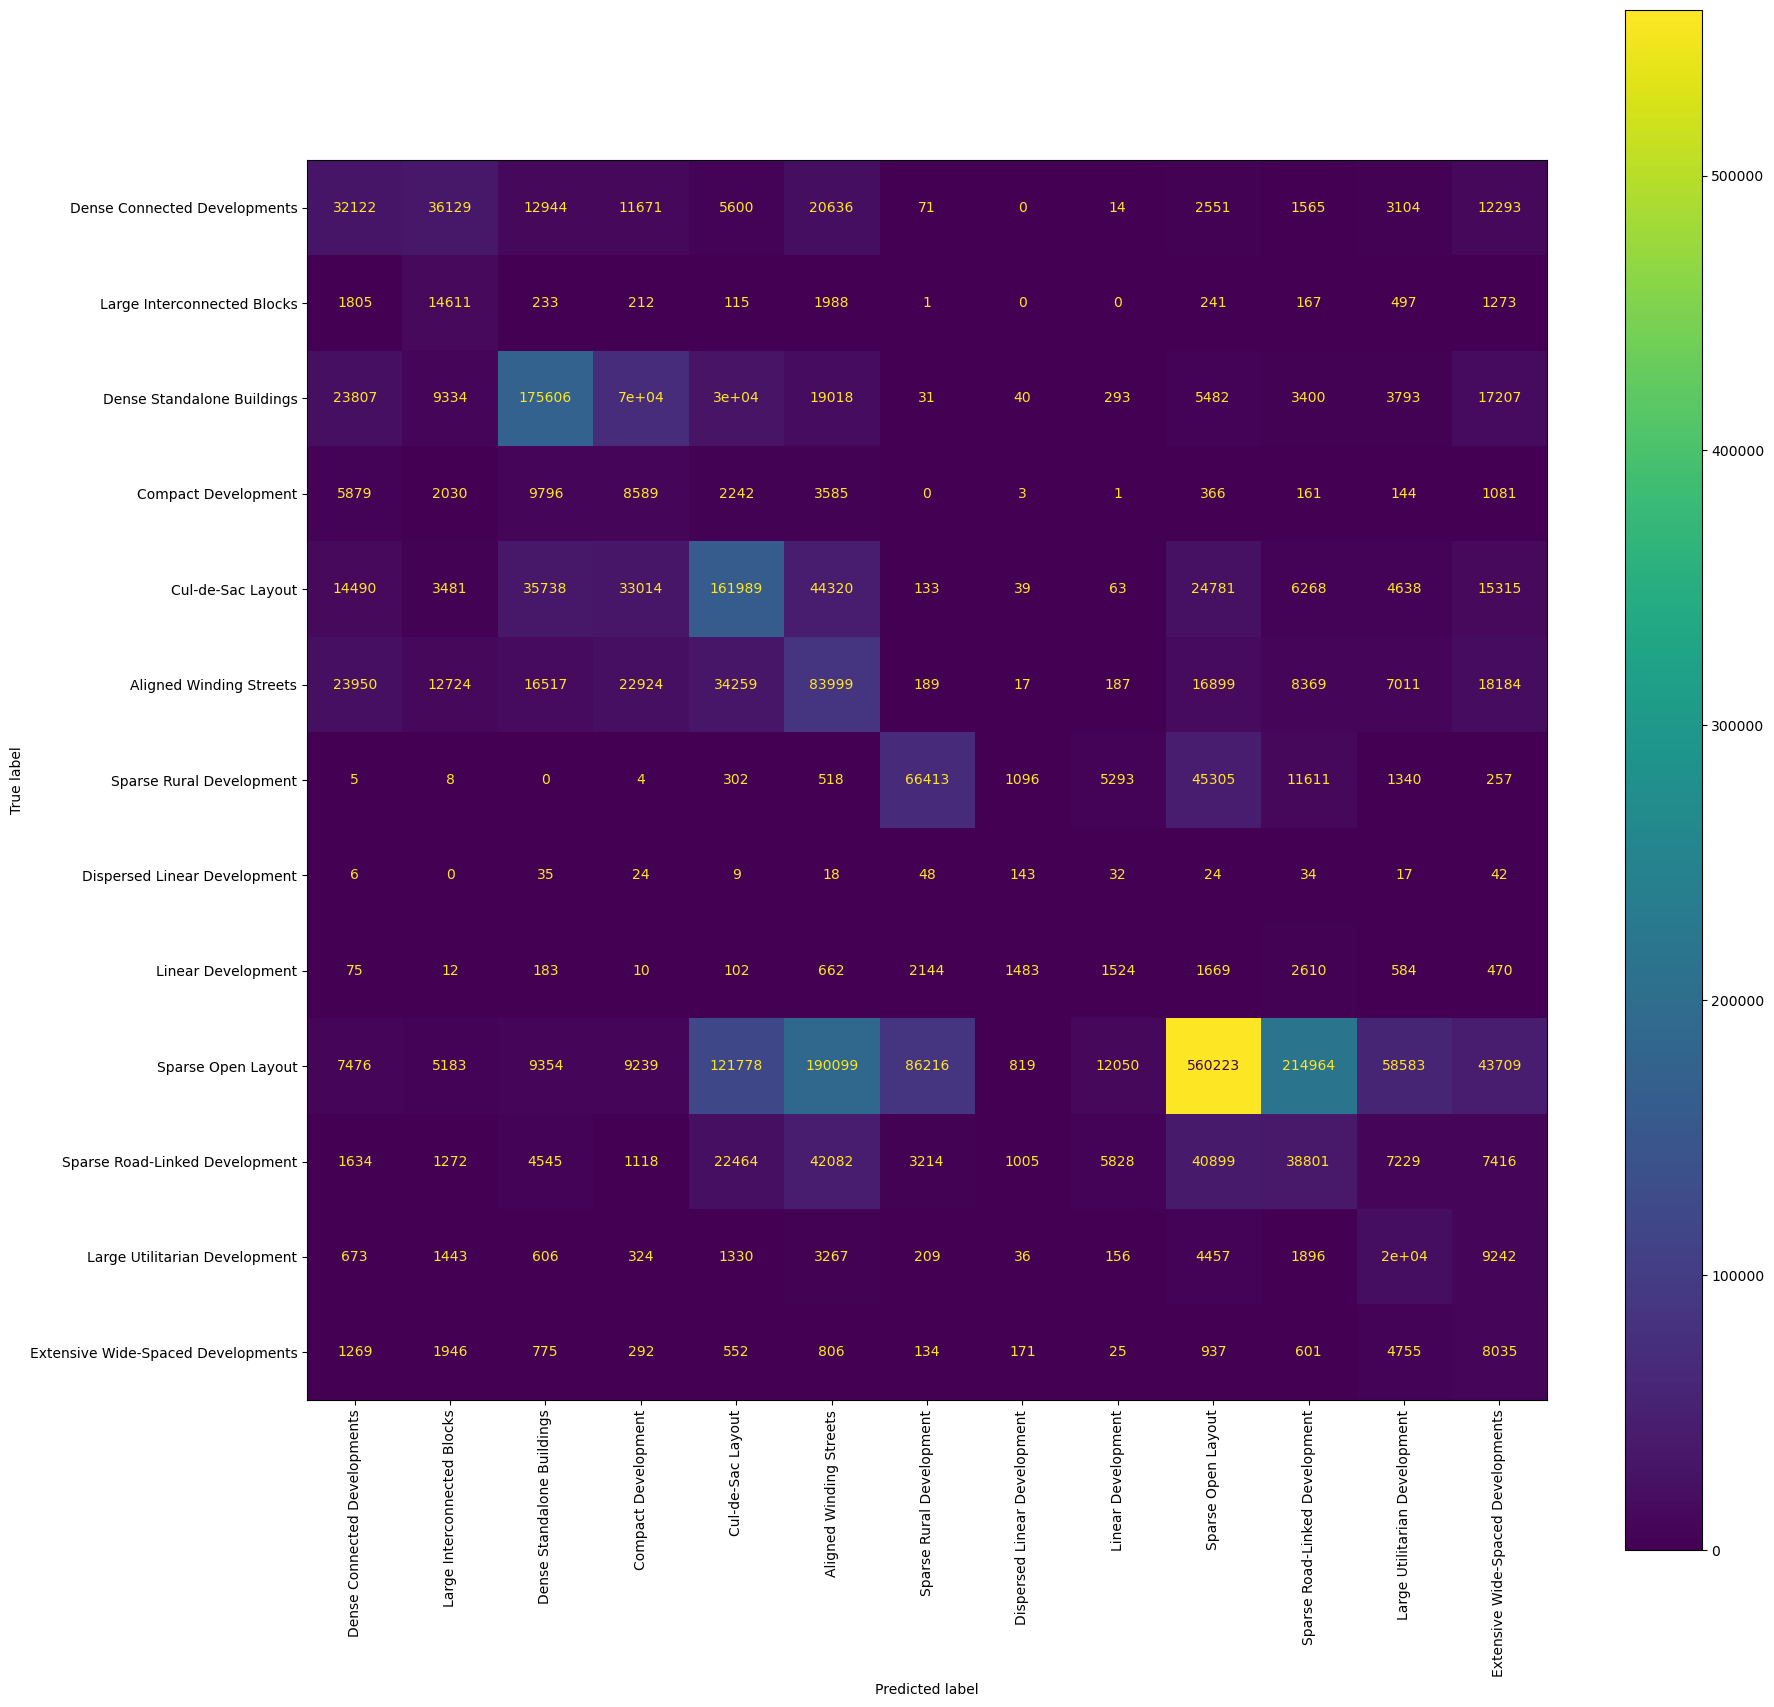

In [148]:
fig,ax = plt.subplots(figsize=(20,20))
disp.plot( xticks_rotation = 'vertical', ax=ax)

### Plot predictions

In [35]:
from lonboard import SolidPolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12
from core.cluster_validation import get_color

In [36]:
region_id = 84986 

In [37]:
buildings = gpd.read_parquet(f'/data/uscuni-eurofab/processed_data/buildings/buildings_{region_id}.parquet')

In [38]:
labels = y_test[y_test.index.str.startswith(str(region_id))].final_without_noise
labels.index = labels.index.str.split('_').str[-1].astype(int)

In [44]:
buildings["predicted_label"] = pd.Series(mapped_predictions[X_test.index.str.startswith('84986')], labels.index)
buildings["true_label"] = labels

In [45]:
layer = SolidPolygonLayer.from_geopandas(
    gdf=buildings[["geometry", "predicted_label", 'true_label']], get_fill_color=get_color(buildings['true_label'].values.astype(int)), opacity=0.15
)

/tmp/ipykernel_34647/1019886908.py:2: RuntimeWarning: invalid value encountered in cast
  gdf=buildings[["geometry", "predicted_label", 'true_label']], get_fill_color=get_color(buildings['true_label'].values.astype(int)), opacity=0.15
/home/krasen/morphometrics/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


In [46]:
m = Map(layer, basemap_style=CartoBasemap.Positron)
m

Map(basemap_style=<CartoBasemap.Positron: 'https://basemaps.cartocdn.com/gl/positron-gl-style/style.json'>, la…

In [47]:
layer.get_fill_color = get_color(buildings['predicted_label'].values.astype(int))

/tmp/ipykernel_34647/2610499029.py:1: RuntimeWarning: invalid value encountered in cast
  layer.get_fill_color = get_color(buildings['predicted_label'].values.astype(int))
